In [1]:
!pip3 install pyro-ppl

In [0]:
# Load the dataset and some utility functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.utils.data as utils
import torch.nn.functional as F
import torch.optim as optim
from pyro.distributions.torch import Normal
from pyro.distributions.torch import Categorical

import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


# If GPU is available set it to a GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import pyro
import matplotlib.pyplot as plt

In [3]:
normalize = transforms.Normalize((0.0,),(1/255.0,)) 
data_dir = "data/"

# Get TRAINING and VALIDATION datasets
# Define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
    ])
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=0),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=train_transform)

valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=valid_transform)

# Get 20% as a validation dataset
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

np.random.seed(1234)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=64, sampler=train_sampler, 
                num_workers=8)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler, 
                num_workers=8)

    # define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

test_dataset = datasets.MNIST(root=data_dir, 
                           train=False, 
                           download=True,
                           transform=transform)


test_loader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=32, 
                                        shuffle=True, 
                                        num_workers=8)

examples = enumerate(train_loader)
print(next(examples))

(0, [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..

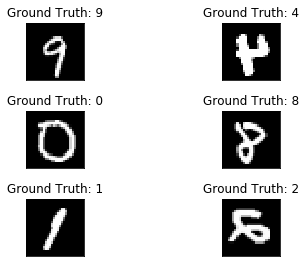

In [4]:
fig = plt.figure()
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.tight_layout()
    _, (image, label) = next(examples)
    i = np.random.randint(0,63)
    plt.imshow(torch.squeeze(image[i]), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(label[i].item()))
    plt.xticks([])
    plt.yticks([])

In [5]:
# Define a very simple model consisting of 4 inputs, 10 input nodes and 4 output nodes
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1   = torch.nn.Linear(256, 120)
        self.fc2   = torch.nn.Linear(120, 84)
        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
net = LeNet()
net.to(DEVICE)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
# Define an optimiser
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
# Just a utility function to calculate the accuracy
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs==labels)/float(labels.size)

In [8]:
EPOCHS = 5

train_loss = []
val_loss = []

train_acc = []
val_acc = []

with torch.no_grad():
    t = net(train_dataset.data.unsqueeze(1).float().to(DEVICE))
    v = net(valid_dataset.data.unsqueeze(1).float().to(DEVICE))
    t_loss = criterion(t, train_dataset.targets.to(DEVICE))
    v_loss = criterion(v, valid_dataset.targets.to(DEVICE))
    train_loss.append(t_loss.item())
    val_loss.append(v_loss.item())
    train_acc.append(accuracy(t.cpu().numpy(),train_dataset.targets.numpy()))
    val_acc.append(accuracy(v.cpu().numpy(),valid_dataset.targets.numpy()))
    print("Training accuracy: {0:.2f}".format(train_acc[-1]))
    print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

    # The main training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    with torch.no_grad():
        t = net(train_dataset.data.unsqueeze(1).float().to(DEVICE))
        v = net(valid_dataset.data.unsqueeze(1).float().to(DEVICE))
        t_loss = criterion(t, train_dataset.targets.to(DEVICE))
        v_loss = criterion(v, valid_dataset.targets.to(DEVICE))
        train_loss.append(t_loss.item())
        val_loss.append(v_loss.item())
        train_acc.append(accuracy(t.cpu().numpy(),train_dataset.targets.numpy()))
        val_acc.append(accuracy(v.cpu().numpy(),valid_dataset.targets.numpy()))
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))
        
print('Finished Training')

Training accuracy: 0.09
Validation accuracy: 0.09
Training accuracy: 0.95
Validation accuracy: 0.95
Training accuracy: 0.97
Validation accuracy: 0.97
Training accuracy: 0.97
Validation accuracy: 0.97
Training accuracy: 0.98
Validation accuracy: 0.98
Training accuracy: 0.97
Validation accuracy: 0.97
Finished Training


AttributeError: ignored

In [9]:
with torch.no_grad():
    print("Test accuracy: {0:.2f}".format(accuracy(net(test_dataset.data.unsqueeze(1).float().to(DEVICE)).cpu().numpy(),test_dataset.targets.cpu().numpy())))

Test accuracy: 0.97


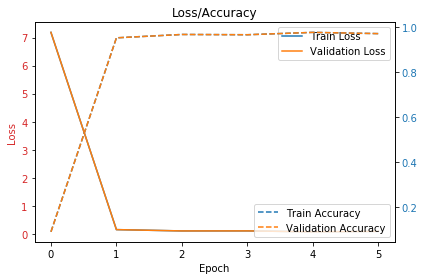

In [10]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Validation Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_acc,linestyle='dashed',label="Train Accuracy")
ax2.plot(val_acc,linestyle='dashed',label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()

plt.title("Loss/Accuracy")
fig.tight_layout()